In [32]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tables
from astropy.table import Table

from scipy.stats import binned_statistic_2d

In [2]:
data = Table.read("15891_SMC-1588ne-12105_beast_stats.fits", hdu=1 )

### Yumi Plots

In [41]:
def scatter_CMD(params, chi2min=10, save=None):
    fig, ax = plt.subplots(2,2, figsize=(12,10))
    ax = ax.ravel()
    
    # convert to VEGA mags
    filters = ["HST_WFC3_F475W", "HST_WFC3_F814W",]

    hdf = tables.open_file("../../.beast/vega.hd5")

    FNAME = hdf.root.sed.cols.FNAME[:]
    MAG = hdf.root.sed.cols.MAG[:]
    LUM = hdf.root.sed.cols.LUM[:]
    CWAVE = hdf.root.sed.cols.CWAVE[:]

    idx = np.asarray([np.where(FNAME == k.encode("utf-8")) for k in filters])
    np.ravel(FNAME[idx]), np.ravel(CWAVE[idx]), np.ravel(MAG[idx]), 

    vega_flux_f475w = np.ravel(LUM[idx])[0]
    vega_flux_f814w = np.ravel(LUM[idx])[1]
    
    print(vega_flux_f475w, vega_flux_f814w)
    
    data["F814W_VEGA"] = -2.5* np.log10(data["HST_WFC3_F814W"] / vega_flux_f814w)
    data["F475W_VEGA"] = -2.5* np.log10(data["HST_WFC3_F475W"] / vega_flux_f475w)
    data["F475W-F814W"] = data["F475W_VEGA"] - data["F814W_VEGA"]


    for i, p in enumerate(params):
        
        

        cbar = ax[i].scatter(data["F475W-F814W"][data['chi2min'] < chi2min], 
                      data["F475W_VEGA"][data['chi2min'] < chi2min],
                      cmap="viridis",
                      c=data[p][data['chi2min'] < chi2min],
                      s=1,
                      alpha=0.5
                     )

        ax[i].set_xlabel("F475W-F814W")
        ax[i].set_ylabel("F475W")

        fig.colorbar(cbar, ax=ax[i], label=p)

        ax[i].invert_yaxis()


In [45]:
def binned_CMD(params, chi2min=10, bins=(100,100), save=None):

    fig, ax = plt.subplots(2,2, figsize=(12,10))

    ax = ax.ravel()
    
    # convert to VEGA mags
    filters = ["HST_WFC3_F475W", "HST_WFC3_F814W",]

    hdf = tables.open_file("../../.beast/vega.hd5")

    FNAME = hdf.root.sed.cols.FNAME[:]
    MAG = hdf.root.sed.cols.MAG[:]
    LUM = hdf.root.sed.cols.LUM[:]
    CWAVE = hdf.root.sed.cols.CWAVE[:]

    idx = np.asarray([np.where(FNAME == k.encode("utf-8")) for k in filters])
    np.ravel(FNAME[idx]), np.ravel(CWAVE[idx]), np.ravel(MAG[idx]), 

    vega_flux_f475w = np.ravel(LUM[idx])[0]
    vega_flux_f814w = np.ravel(LUM[idx])[1]
    
    print(vega_flux_f475w, vega_flux_f814w)
    
    data["F814W_VEGA"] = -2.5* np.log10(data["HST_WFC3_F814W"] / vega_flux_f814w)
    data["F475W_VEGA"] = -2.5* np.log10(data["HST_WFC3_F475W"] / vega_flux_f475w)
    data["F475W-F814W"] = data["F475W_VEGA"] - data["F814W_VEGA"]

    
    for i, p in enumerate(params):

        x = data["F475W-F814W"][data['chi2min'] < chi2min]
        y = data["F475W_VEGA"][data['chi2min'] < chi2min] 

        # remove all indices with nan values in x or y
        where_nan = np.isnan(x) | np.isnan(y)

        x = x[~where_nan]
        y = y[~where_nan]

        stats = binned_statistic_2d(x,
                                    y,
                                    data[p][data['chi2min'] < chi2min][~where_nan],
                                    bins=bins)

        cbar = ax[i].pcolor(stats.statistic.T,
                            cmap='viridis',    
                                   )


        fig.colorbar(cbar, ax=ax[i], label=p)

        # relabel x-axis
        xticks = ax[i].get_xticks()
        sep_xticks = int(xticks[1] - xticks[0])
        ax[i].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])

        # relabel y-axis
        yticks = ax[i].get_yticks()
        sep_yticks = int(yticks[1] - yticks[0])
        ax[i].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])

        ax[i].set_xlabel("F475W-F814W")
        ax[i].set_ylabel("F475W")

        ax[i].invert_yaxis()
        
        if save:
            plt.savefig(save)
            
    return


In [38]:
def binned_spatial(params, chi2min=10, bins=(100, 100), save=None):
    
    fig, ax = plt.subplots(2,2, figsize=(13,10))
    ax = ax.ravel()

    for i, p in enumerate(params):

        stats = binned_statistic_2d(data['RA'][data['chi2min'] < chi2min],
                                    data['DEC'][data['chi2min'] < chi2min],
                                    data[p][data['chi2min'] < chi2min],
                                    bins=bins)

        cbar = ax[i].pcolor(stats.statistic.T,
                            cmap='viridis_r',    
                                   )


        fig.colorbar(cbar, ax=ax[i], label=p)

        # relabel x-axis
        xticks = ax[i].get_xticks()
        sep_xticks = int(xticks[1] - xticks[0])
        ax[i].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])

        # relabel y-axis
        yticks = ax[i].get_yticks()
        sep_yticks = int(yticks[1] - yticks[0])
        ax[i].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])

        ax[i].set_xlabel("RA")
        ax[i].set_ylabel("DEC")

        if save:
                plt.savefig(save)

5.282005839341959e-09 1.0469882848585408e-09


<ipython-input-41-3dcf56927ed8>:23: RuntimeWarning: invalid value encountered in log10
  data["F814W_VEGA"] = -2.5* np.log10(data["HST_WFC3_F814W"] / vega_flux_f814w)
<ipython-input-41-3dcf56927ed8>:24: RuntimeWarning: invalid value encountered in log10
  data["F475W_VEGA"] = -2.5* np.log10(data["HST_WFC3_F475W"] / vega_flux_f475w)


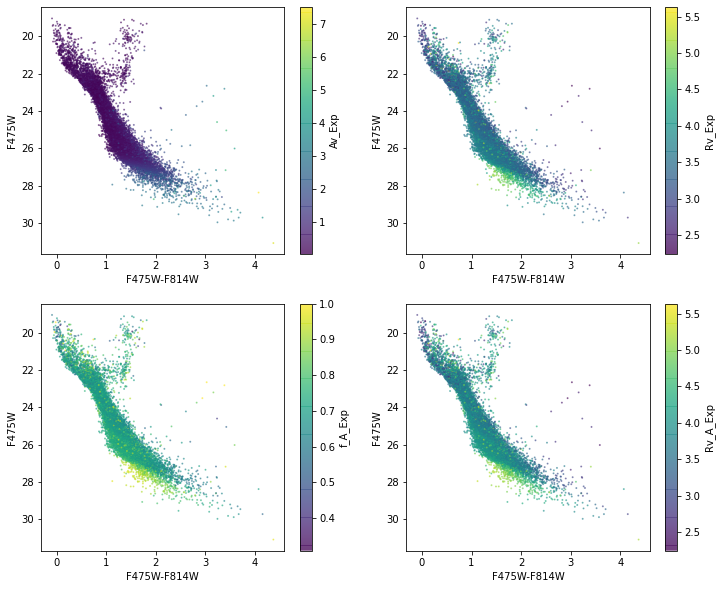

In [42]:
scatter_CMD(["Av_Exp", "Rv_Exp", "f_A_Exp", "Rv_A_Exp"])

5.282005839341959e-09 1.0469882848585408e-09


<ipython-input-45-14e7f9bd4402>:25: RuntimeWarning: invalid value encountered in log10
  data["F814W_VEGA"] = -2.5* np.log10(data["HST_WFC3_F814W"] / vega_flux_f814w)
<ipython-input-45-14e7f9bd4402>:26: RuntimeWarning: invalid value encountered in log10
  data["F475W_VEGA"] = -2.5* np.log10(data["HST_WFC3_F475W"] / vega_flux_f475w)
<ipython-input-45-14e7f9bd4402>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])
<ipython-input-45-14e7f9bd4402>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])
<ipython-input-45-14e7f9bd4402>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])
<ipython-input-45-14e7f9bd4402>:61: UserWarning: FixedFormatter should only be used togeth

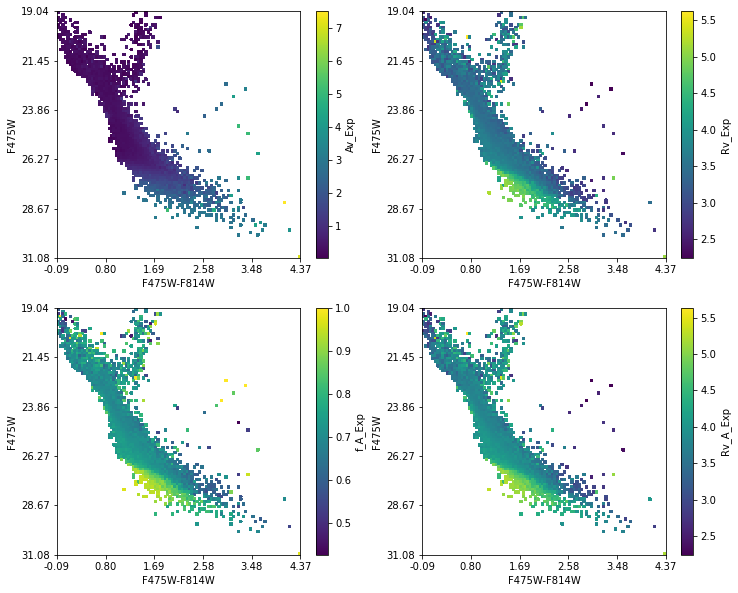

In [50]:
binned_CMD(["Av_Exp", "Rv_Exp", "f_A_Exp", "Rv_A_Exp"], bins=(100,100), chi2min=10, save="test.pdf")

<ipython-input-4-f0463ebf5726>:9: RuntimeWarning: invalid value encountered in log10
  x = -2.5*np.log10(data['HST_WFC3_F475W'][data['chi2min'] < chi2min]) + 2.5*np.log10(data['HST_WFC3_F814W'][data['chi2min'] < chi2min])
<ipython-input-4-f0463ebf5726>:10: RuntimeWarning: invalid value encountered in log10
  y = -2.5*np.log10(data['HST_WFC3_F475W'][data['chi2min'] < chi2min])
<ipython-input-4-f0463ebf5726>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])
<ipython-input-4-f0463ebf5726>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])


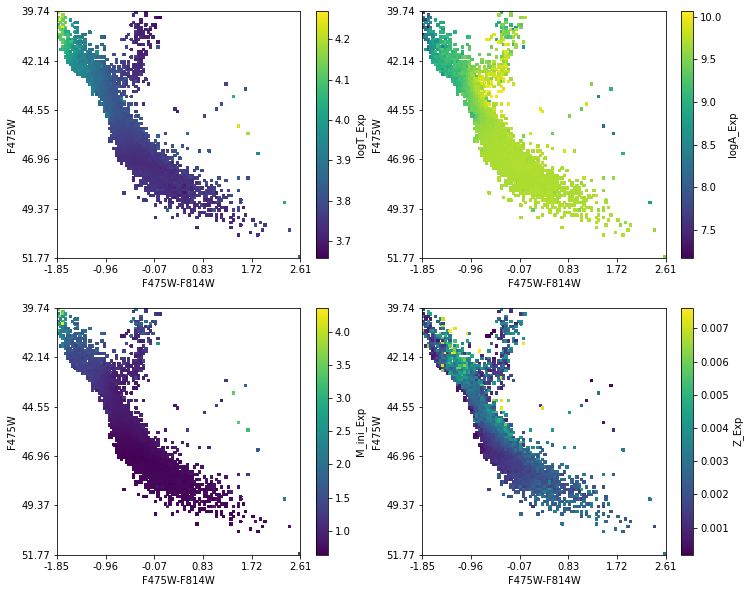

In [8]:
binned_CMD(["logT_Exp", "logA_Exp", "M_ini_Exp", "Z_Exp"], chi2min=10)

<ipython-input-38-83632e9a6d84>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])
<ipython-input-38-83632e9a6d84>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])


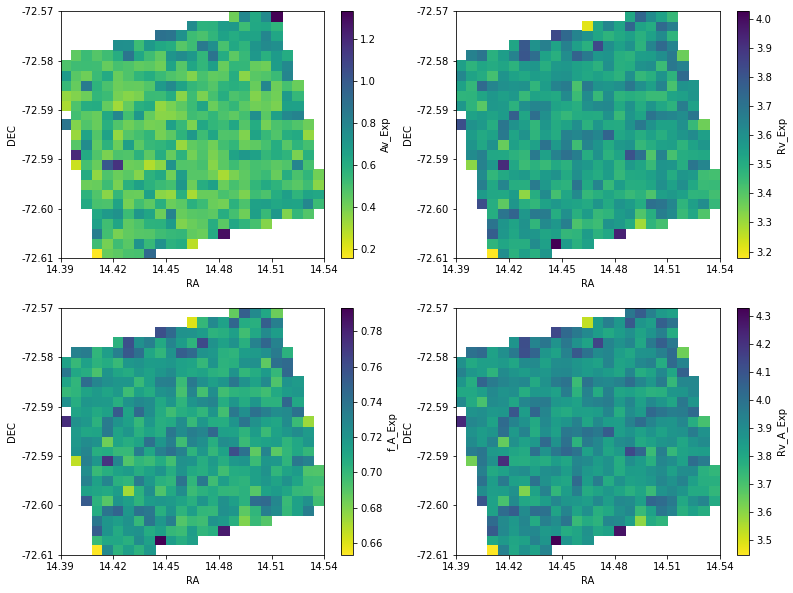

In [54]:
binned_spatial(["Av_Exp", "Rv_Exp", "f_A_Exp", "Rv_A_Exp"], bins=(25, 25), chi2min=10)

<ipython-input-5-83632e9a6d84>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])
<ipython-input-5-83632e9a6d84>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])


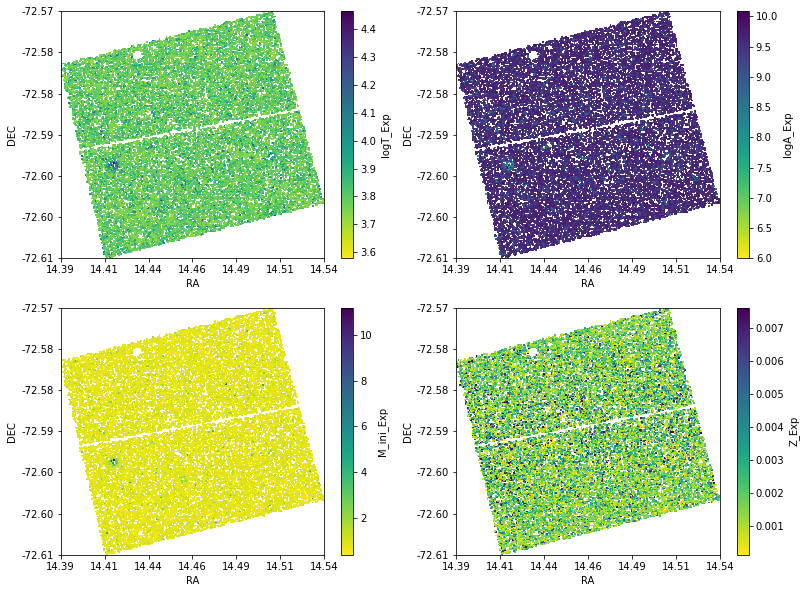

In [10]:
binned_spatial(["logT_Exp", "logA_Exp", "M_ini_Exp", "Z_Exp"], chi2min=10000000, bins=(300,300))

<ipython-input-38-83632e9a6d84>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])
<ipython-input-38-83632e9a6d84>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])


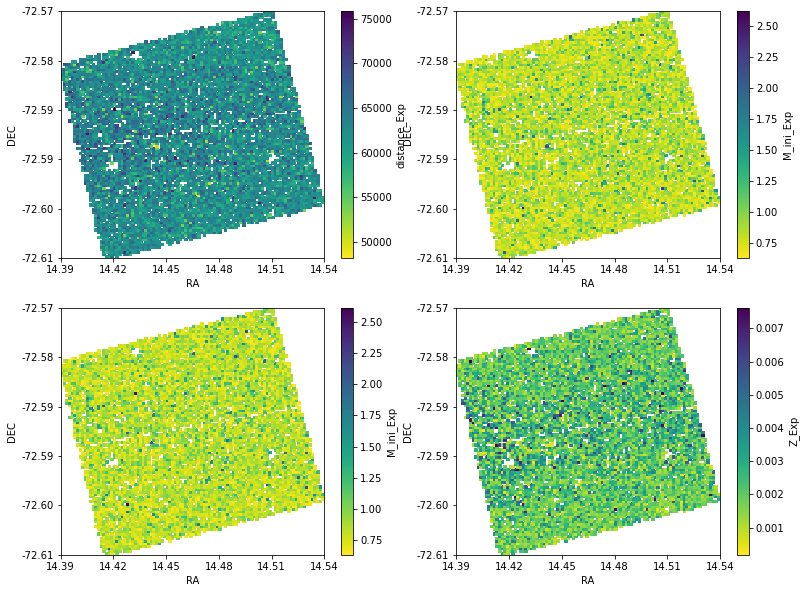

In [57]:
binned_spatial(["distance_Exp", "M_ini_Exp", "M_ini_Exp", "Z_Exp"], chi2min=10, bins=(100,100))

<ipython-input-11-b29d516c74e5>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])
<ipython-input-11-b29d516c74e5>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])


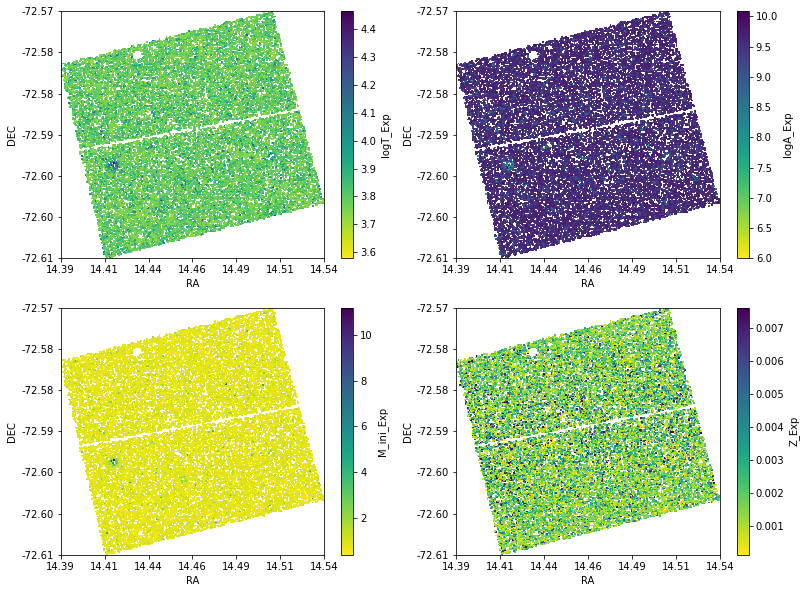

In [11]:
fig, ax = plt.subplots(2,2, figsize=(13,10))

ax = ax.ravel()

params = ["logT_Exp", "logA_Exp", "M_ini_Exp", "Z_Exp"]

for i, p in enumerate(params):
    
    stats = binned_statistic_2d(data['RA'],
                                data['DEC'],
                                data[p],
                                bins=(300, 300))

    cbar = ax[i].pcolor(stats.statistic.T,
                        cmap='viridis_r',    
                               )


    fig.colorbar(cbar, ax=ax[i], label=p)

    # relabel x-axis
    xticks = ax[i].get_xticks()
    sep_xticks = int(xticks[1] - xticks[0])
    ax[i].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])

    # relabel y-axis
    yticks = ax[i].get_yticks()
    sep_yticks = int(yticks[1] - yticks[0])
    ax[i].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])

    ax[i].set_xlabel("RA")
    ax[i].set_ylabel("DEC")
#plt.savefig('test2.pdf')

### BEAST Paper Plots

Text(0.5, 0, 'log($T_{eff}$) [K]')

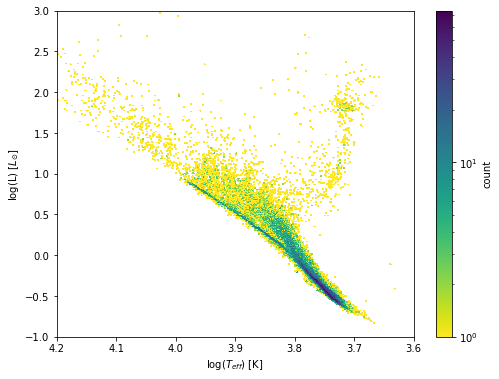

In [12]:
# HR Diagram (Fig. 15)
fig, ax = plt.subplots(1,1, figsize=(8,6))

h, xedg, yedg, cbar = ax.hist2d(data['logT_Exp'],
                      data['logL_Exp'],
                      bins=(500, 500),
                      cmap=mpl.cm.viridis_r,
                      norm=mpl.colors.LogNorm()
                            )

fig.colorbar(cbar, ax=ax, label="count")
ax.invert_xaxis()
ax.set_xlim([4.2, 3.6])
ax.set_ylim([-1, 3])

ax.set_ylabel("log(L) [$L_{\odot}$]")
ax.set_xlabel("log($T_{eff}$) [K]")

In [13]:
def uncertainty_plot(params, save=None):
    """
    Recreates uncertainty plots (Fig. 16+17+18) from the BEAST paper 
    (Gordon et al. 2016).
    
    Parameters
    ----------
    params : list
        Name of BEAST parameters/column name to plot. Expects the 
        parameter column name ending in 'Exp'
    save : string
        Save the figure as e.g. 'fig.png' or 'fig.pdf'. Won't save if left
        blank.
    
    """
    #
    from scipy.stats import binned_statistic_2d

    fig, ax = plt.subplots(len(params),2, figsize=(12,4*len(params)))
    ax = ax.ravel()

    for i, p in enumerate(params):   

        # value vs 1-sigma uncertainty ((p84-p16)/2)
        h, xedg, yedg, cbar = ax[i*2].hist2d(data[p],
                              (data[p.replace("Exp", "p84")]-data[p.replace("Exp", "p16")])/2,
                              bins=(200, 200),
                              cmap=mpl.cm.viridis_r,
                              norm=mpl.colors.LogNorm()
                                    )

        fig.colorbar(cbar, ax=ax[i*2], label="count")

        ax[i*2].set_xlabel(p)
        ax[i*2].set_ylabel("$\sigma$ "+ p.replace("_Exp", ""))

        # HR Diagram
        stats = binned_statistic_2d(data['logT_Exp'],
                                    data['logL_Exp'],
                                    (data[p.replace("Exp", "p84")]-data[p.replace("Exp", "p16")])/2,
                                    bins=(200, 200))

        cbar = ax[i*2+1].pcolor(stats.statistic.T,
                               cmap='plasma_r',    
                               )


        fig.colorbar(cbar, ax=ax[i*2+1], label="$\sigma$ "+ p.replace("_Exp", ""))

        # relabel x-axis
        ax[i*2+1].invert_xaxis()
        xticks = ax[i*2+1].get_xticks()
        sep_xticks = int(xticks[1] - xticks[0])
        ax[i*2+1].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])

        # relabel y-axis
        yticks = ax[i*2+1].get_yticks()
        sep_yticks = int(yticks[1] - yticks[0])
        ax[i*2+1].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])

        ax[i*2+1].set_ylabel("log(L) [$L_{\odot}$]")
        ax[i*2+1].set_xlabel("log($T_{eff}$) [K]")

    if save:
        plt.savefig(save)
    
    return


<ipython-input-13-7be648d9ef3b>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i*2+1].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])
<ipython-input-13-7be648d9ef3b>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i*2+1].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])


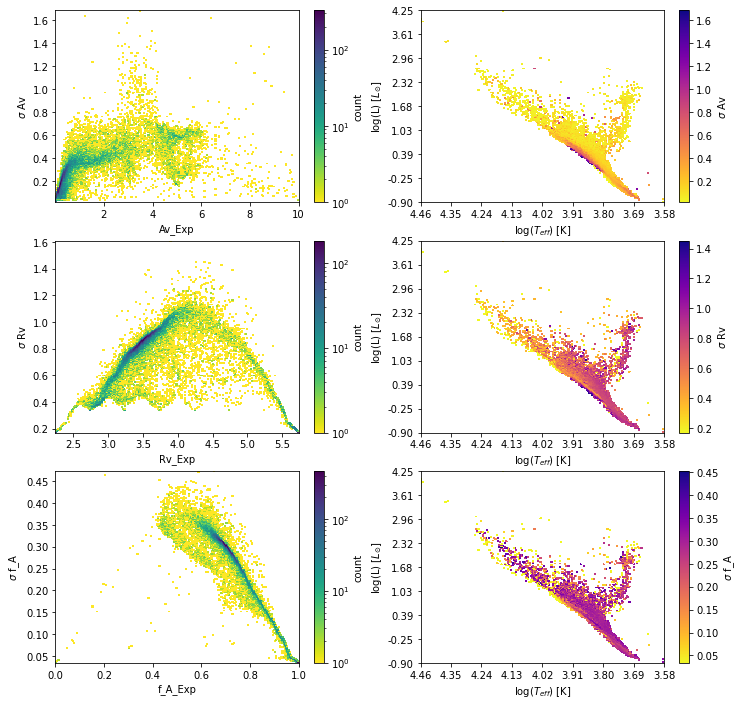

In [14]:
params = ["Av_Exp", "Rv_Exp", "f_A_Exp"]

uncertainty_plot(params, save="dust_params.pdf")

<ipython-input-13-7be648d9ef3b>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i*2+1].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])
<ipython-input-13-7be648d9ef3b>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i*2+1].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])


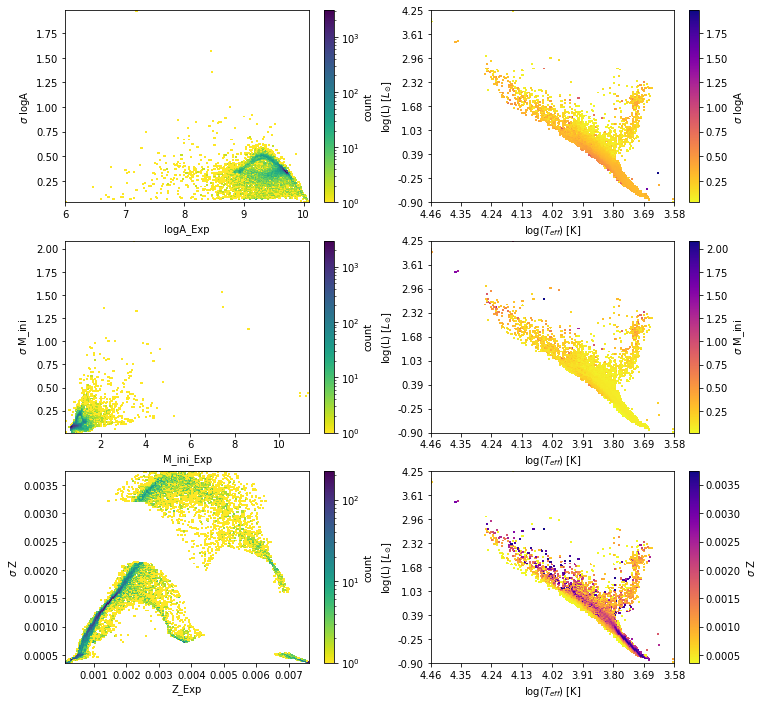

In [15]:
params = ["logA_Exp", "M_ini_Exp", "Z_Exp"]

uncertainty_plot(params, save="stellar_params.pdf")

In [ ]:
data['distance_Exp']

<ipython-input-13-7be648d9ef3b>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i*2+1].set_xticklabels([format(i, ".2f") for i in stats.x_edge[0::sep_xticks]])
<ipython-input-13-7be648d9ef3b>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i*2+1].set_yticklabels([format(i, ".2f") for i in stats.y_edge[0::sep_yticks]])


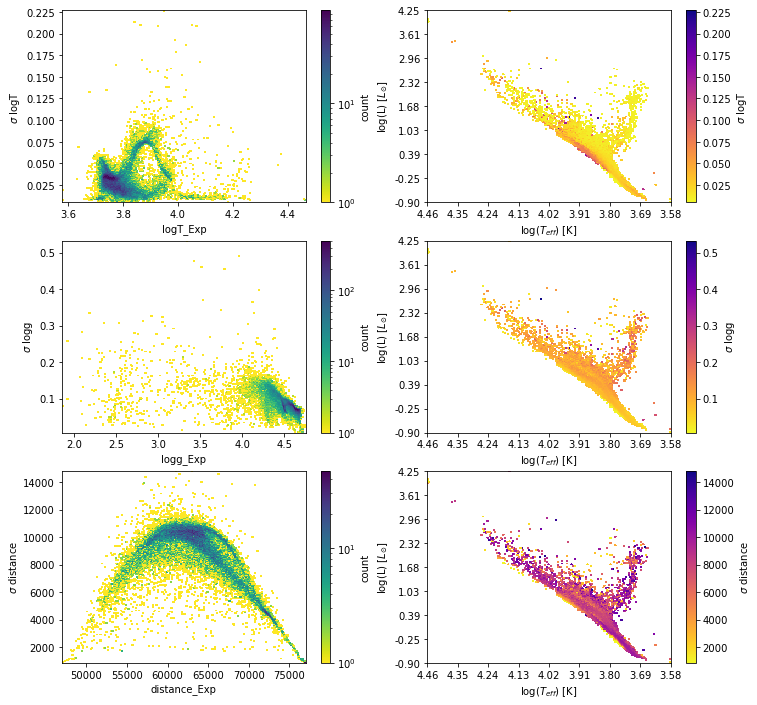

In [55]:
params = ["logT_Exp", "logg_Exp", "distance_Exp"]

uncertainty_plot(params, save="stellar_params2.pdf")

### More plots!
Combinations of BEAST fit parameters.  E.g., A(V) vs R(V).  And R(V) vs f_A.  And A(V) vs T_eff.

In [116]:
def binned_2D(data, params, chi2min=10, bins=(100,100), cmap='viridis_r', label=None, save=None):

    fig, ax = plt.subplots(2,2, figsize=(12,10))

    ax = ax.ravel()
    
    for i, p in enumerate(params):

        h, xedg, yedg, cbar = ax[i].hist2d(data[p[0]][data['chi2min'] < chi2min],
                                        data[p[1]][data['chi2min'] < chi2min],
                                        bins=bins,
                                        cmap=cmap,
                                        norm=mpl.colors.LogNorm(),
                                        )

        fig.colorbar(cbar, ax=ax[i], label="count")

        ax[i].set_xlabel(p[0])
        ax[i].set_ylabel(p[1])
        
        plt.tight_layout()
        
        if save:
            plt.savefig(save)
            
    return

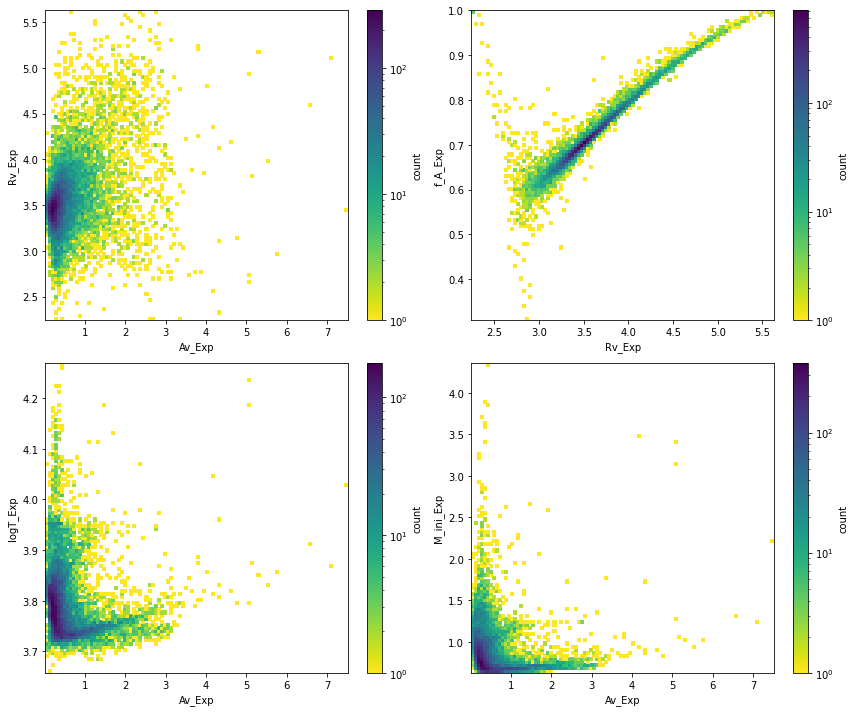

In [108]:
binned_2D(data, params=[["Av_Exp", "Rv_Exp"], ["Rv_Exp", "f_A_Exp"], ["Av_Exp", "logT_Exp"], ["Av_Exp", "M_ini_Exp"]])

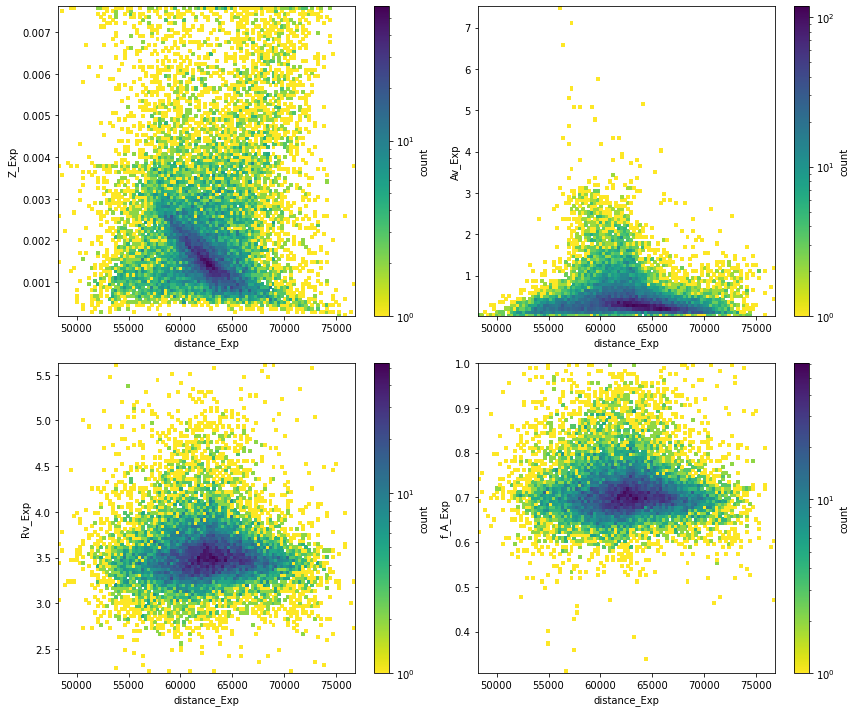

In [110]:
binned_2D(data, params = [["distance_Exp", "Z_Exp"], ["distance_Exp", "Av_Exp"], ["distance_Exp", "Rv_Exp"], ["distance_Exp", "f_A_Exp"]],)

### Red Clump Stars

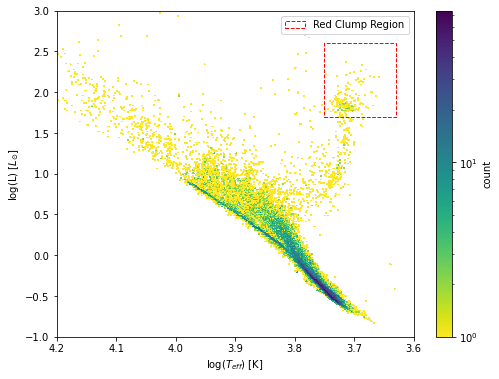

In [99]:
import matplotlib.patches as patches

# HR Diagram (Fig. 15)
fig, ax = plt.subplots(1,1, figsize=(8,6))

h, xedg, yedg, cbar = ax.hist2d(data['logT_Exp'],
                      data['logL_Exp'],
                      bins=(500, 500),
                      cmap=mpl.cm.viridis_r,
                      norm=mpl.colors.LogNorm()
                            )

rc_square = patches.Rectangle((3.75, 1.7), -0.12, 0.9, linewidth=1, 
                              edgecolor='r', 
                              linestyle="dashed", 
                              facecolor='none',
                              label="Red Clump Region")
ax.add_patch(rc_square)

fig.colorbar(cbar, ax=ax, label="count")
ax.invert_xaxis()
ax.set_xlim([4.2, 3.6])
ax.set_ylim([-1, 3])

ax.set_ylabel("log(L) [$L_{\odot}$]")
ax.set_xlabel("log($T_{eff}$) [K]")

ax.legend()

In [100]:
temp = data[data['logL_Exp']>=1.7]
rc_data = temp[temp["logT_Exp"]<3.75]

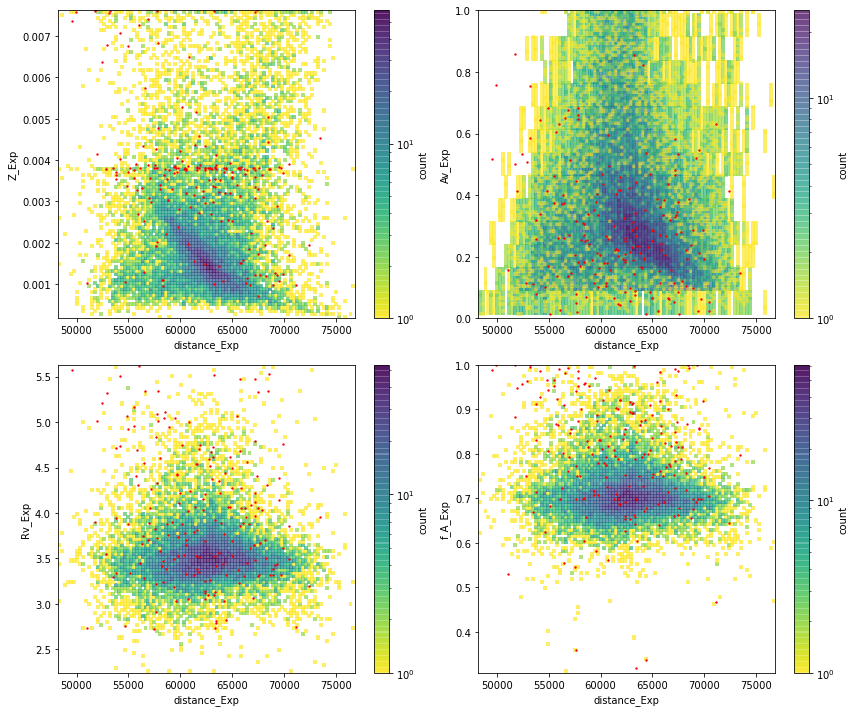

In [134]:
params = [["distance_Exp", "Z_Exp"], ["distance_Exp", "Av_Exp"], ["distance_Exp", "Rv_Exp"], ["distance_Exp", "f_A_Exp"]]
bins=(100,100)
cmap="viridis_r"
save=None
                                                                                              
fig, ax = plt.subplots(2,2, figsize=(12,10))

ax = ax.ravel()

for i, p in enumerate(params):

    h, xedg, yedg, cbar = ax[i].hist2d(data[p[0]][data['chi2min'] < chi2min],
                                    data[p[1]][data['chi2min'] < chi2min],
                                    bins=bins,
                                    cmap=cmap,
                                    norm=mpl.colors.LogNorm(),
                                    alpha=0.7)

    if i==1:
        xmin, xmax = ax[i].get_xlim()
        h, xedg, yedg, cbar = ax[i].hist2d(data[p[0]][data['chi2min'] < chi2min],
                                    data[p[1]][data['chi2min'] < chi2min],
                                    bins=bins,
                                    range=[[xmin, xmax], [0, 1]],
                                    cmap=cmap,
                                    norm=mpl.colors.LogNorm(),
                                    alpha=0.5)
    
    ax[i].scatter(rc_data[p[0]], 
                  rc_data[p[1]],
                  c="r",
                  marker=".",
                  s=7)
                                                                                              

    fig.colorbar(cbar, ax=ax[i], label="count")

    ax[i].set_xlabel(p[0])
    ax[i].set_ylabel(p[1])
    
#     if i==1:
#         ax[i].set_ylim([0,1.5])

    plt.tight_layout()

    if save:
        plt.savefig(save)